In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random



In [32]:
def generate_gaussian_pulse(length, center, amplitude, width):
    """Creates a bell-curve shape to simulate a cell passing through the sensor."""
    t = np.arange(length)
    pulse = amplitude * np.exp(-((t - center) ** 2) / (2 * width ** 2))
    return pulse



Generating 150 synthetic cells...
Dataset generated and saved!
cell_type
RBC         88
Platelet    56
WBC          6
Name: count, dtype: int64


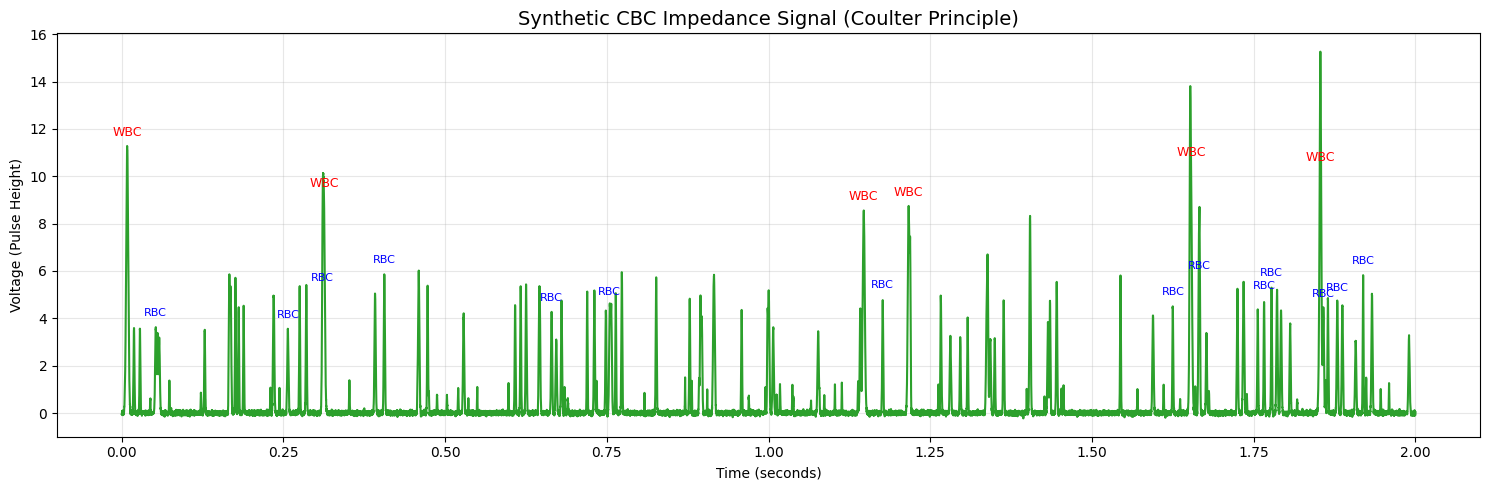

In [56]:
def generate_synthetic_cbc_data(num_samples=1000, duration_sec=1.0, sampling_rate=10000):
    """
    Generates a synthetic time-series signal representing blood cells passing an electrode.
    
    Params:
    - num_samples: How many 'cells' to simulate in this batch.
    - duration_sec: Length of the signal in seconds.
    - sampling_rate: How many data points per second (Hz).
    """
    
    total_points = int(duration_sec * sampling_rate)
    time_axis = np.linspace(0, duration_sec, total_points)
    
    # 1. Base Signal (The baseline voltage)
    voltage_signal = np.zeros(total_points)
    
    # 2. Add Noise (Real electronics always have static/noise)
    noise_level = 0.05
    noise = np.random.normal(0, noise_level, total_points)
    voltage_signal += noise
    
    # Track ground truth for training the AI later
    labels = []  # Stores: [pulse_start_index, pulse_end_index, cell_type]
    
    # Cell Definitions (Approximate relative sizes for Coulter Principle)
    # Class 0: Platelet (Small)
    # Class 1: RBC (Medium)
    # Class 2: WBC (Large)
    
    print(f"Generating {num_samples} synthetic cells...")
    
    for _ in range(num_samples):
        cell_type = np.random.choice(['Platelet', 'RBC', 'WBC'], p=[0.4, 0.55, 0.05])
        
        if cell_type == 'Platelet':
            amp = np.random.uniform(0.5, 1.5)  # Low voltage spike
            width = np.random.uniform(3, 5)    # Fast transit
            class_id = 0
        elif cell_type == 'RBC':
            amp = np.random.uniform(3.0, 6.0)  # Medium voltage spike
            width = np.random.uniform(6, 10)   # Medium transit
            class_id = 1
        else: # WBC
            amp = np.random.uniform(8.0, 12.0) # High voltage spike
            width = np.random.uniform(12, 18)  # Slow transit (bigger cell)
            class_id = 2
            
        # Pick a random spot in time to insert the cell
        center_loc = np.random.randint(50, total_points - 50)
        
        # Create the pulse
        pulse = generate_gaussian_pulse(total_points, center_loc, amp, width)
        
        # Add pulse to the main signal line
        voltage_signal += pulse
        
        # Save the label (Where is the cell? What is it?)
        labels.append({
            'timestamp': time_axis[center_loc],
            'amplitude': amp,
            'width': width,
            'cell_type': cell_type,
            'class_id': class_id
        })

    # Create a DataFrame for the signal
    df_signal = pd.DataFrame({
        'Time': time_axis,
        'Voltage': voltage_signal
    })
    
    # Create a DataFrame for the Labels (The "Answers" for your AI)
    df_labels = pd.DataFrame(labels)
    
    return df_signal, df_labels

# --- EXECUTION ---

# Generate the data
df_signal, df_labels = generate_synthetic_cbc_data(num_samples=150, duration_sec=2.0)

# Save to CSV (This is your "Dataset" for the Hackathon)
df_signal.to_csv('synthetic_impedance_signal.csv', index=False)
df_labels.to_csv('synthetic_ground_truth.csv', index=False)

print("Dataset generated and saved!")
print(df_labels['cell_type'].value_counts())

# --- VISUALIZATION (Show this graph in your Hackathon Pitch!) ---
plt.figure(figsize=(15, 5))
plt.plot(df_signal['Time'], df_signal['Voltage'], color='#2ca02c', label='Raw Impedance Signal')
plt.title('Synthetic CBC Impedance Signal (Coulter Principle)', fontsize=14)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (Pulse Height)')
plt.grid(True, alpha=0.3)

# Highlight a few peaks
for index, row in df_labels.iterrows():
    if row['cell_type'] == 'WBC':
        plt.text(row['timestamp'], row['amplitude'] + 0.5, 'WBC', color='red', fontsize=9, ha='center')
    elif row['cell_type'] == 'RBC':
        # Only label a few RBCs to avoid clutter
        if random.random() > 0.8: 
            plt.text(row['timestamp'], row['amplitude'] + 0.5, 'RBC', color='blue', fontsize=8, ha='center')

plt.tight_layout()
plt.show()

In [34]:
df_labels['timestamp'] = df_labels['timestamp']/100
# df_labels.[sort_index()
df_labels = df_labels.sort_values(by='timestamp').reset_index(drop=True)
df_labels


,timestamp,amplitude,width,cell_type,class_id
0,0.000078,5.192609,9.080223,RBC,1
1,0.000122,4.857741,8.556694,RBC,1
2,0.000155,0.775450,3.224541,Platelet,0
3,0.000253,11.650728,12.238888,WBC,2
4,0.000367,4.612817,9.845603,RBC,1
...,...,...,...,...,...
495,0.019830,0.550521,4.410087,Platelet,0
496,0.019856,5.858457,7.708264,RBC,1
497,0.019905,0.590405,4.437224,Platelet,0
498,0.019924,5.627759,6.059480,RBC,1


In [35]:
loop = np.linspace(200,800,1000).astype(int)

In [36]:
import numpy as np
import os

# 1. Setup your loop for different sample sizes
sample_counts = np.linspace(200, 800, 100).astype(int) # 100 variations

# Create folders for the "Processed" data
os.makedirs("processed_data", exist_ok=True)

all_pulses = []
all_labels = []

print("Starting Data Extraction...")

for i, count in enumerate(sample_counts):
    # --- Reuse your generation logic here ---
    # Imagine 'signal' is the 10,000 point array and 'labels' are the pulse locations
    # Generate the full 2-second signal (20,000 points)
    signal, df_labels = generate_synthetic_cbc_data(num_samples=count)
    sampling_rate = 10000  # 10,000 points per second
    # 2. For every pulse found, "clip" a window
    for _, row in df_labels.iterrows():
        peak = int(row['timestamp'] * sampling_rate)
        
        # Extract a 60-point window (30 points left, 30 points right of peak)
        # This ensures the peak is centered for the AI
        window = signal[peak - 30 : peak + 30]
        
        # Safety check: only add if window is exactly 60 points
        if len(window) == 60:
            all_pulses.append(window)
            all_labels.append(row['class_id'])  # Or row['class_id'] if you want numeric labels
    
    if i % 10 == 0:
        print(f"Processed {i}% of variations...")

# 3. Convert to NumPy Arrays (This is what AI loves)
X = np.array(all_pulses) # Shape: (Total_Cells, 50)
y = np.array(all_labels) # Shape: (Total_Cells,)

# 4. SAVE THE DATASET
np.save("processed_data/X_train.npy", X)
np.save("processed_data/y_train.npy", y)

print("Done! You now have a single file containing all your training samples.")

Starting Data Extraction...
Generating 200 synthetic cells...
Processed 0% of variations...
Generating 206 synthetic cells...
Generating 212 synthetic cells...
Generating 218 synthetic cells...
Generating 224 synthetic cells...
Generating 230 synthetic cells...
Generating 236 synthetic cells...
Generating 242 synthetic cells...
Generating 248 synthetic cells...
Generating 254 synthetic cells...
Generating 260 synthetic cells...
Processed 10% of variations...
Generating 266 synthetic cells...
Generating 272 synthetic cells...
Generating 278 synthetic cells...
Generating 284 synthetic cells...
Generating 290 synthetic cells...
Generating 296 synthetic cells...
Generating 303 synthetic cells...
Generating 309 synthetic cells...
Generating 315 synthetic cells...
Generating 321 synthetic cells...
Processed 20% of variations...
Generating 327 synthetic cells...
Generating 333 synthetic cells...
Generating 339 synthetic cells...
Generating 345 synthetic cells...
Generating 351 synthetic cells

In [37]:
# here model comes

import numpy as np
import tensorflow as tf
import sklearn as sk
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split



In [38]:
# import sys
# import subprocess

# # 1. See where THIS specific environment is
# print(f"Current Python Path: {sys.executable}")

# # 2. Force install to THAT specific path
# subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
# print("✅ Installation attempted!")

In [39]:
# 1. Load the data you generated
X = np.load("processed_data/X_train.npy")
y = np.load("processed_data/y_train.npy")



In [40]:
X.shape

(49952, 60, 2)

In [41]:
X = X[:, :, 1]

In [42]:
X.shape

(49952, 60)

In [43]:
df_labels['class_id'].value_counts()

class_id
1    436
0    320
2     44
Name: count, dtype: int64

In [44]:
# 2. Reshape for the AI (Needs a 'channel' dimension)
# Current shape: (Samples, 60) -> New shape: (Samples, 60, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(f"Data reshaped for AI: {X.shape}")

# 3. Split into Training and Testing (80% to learn, 20% to test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Build the CNN Architecture
model = models.Sequential([
    # First Layer: Look for small patterns (edges of the pulse)
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,1)),
    layers.MaxPooling1D(pool_size=2),
    
    # Second Layer: Look for larger patterns (the overall peak shape)
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    # Final Layer: Flatten and Decide
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax') # 3 outputs: Platelet, RBC, WBC
])

# 5. Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train the AI!
print("Training the AI on your synthetic blood samples...")
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 7. Save the Brain
model.save("cbc_ai_model.h5")
print("Model saved as 'cbc_ai_model.h5'!")

Data reshaped for AI: (49952, 60, 1)
Training the AI on your synthetic blood samples...
Epoch 1/10


c:\Users\prath\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1249/1249 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7908 - loss: 0.4739 - val_accuracy: 0.8097 - val_loss: 0.4184
Epoch 2/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8292 - loss: 0.3920 - val_accuracy: 0.8307 - val_loss: 0.3888
Epoch 3/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8431 - loss: 0.3675 - val_accuracy: 0.8473 - val_loss: 0.3548
Epoch 4/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8514 - loss: 0.3548 - val_accuracy: 0.8471 - val_loss: 0.3598
Epoch 5/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8541 - loss: 0.3482 - val_accuracy: 0.8455 - val_loss: 0.3582
Epoch 6/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8573 - loss: 0.3420 - val_accuracy: 0.8529 - val_loss: 0.3444
Epoch 7/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8580 - loss: 0.3367 - val_accuracy: 0.8512 - val_loss: 0.3519
Epoch 8/10
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8601 - loss: 0.3335 - val_accu

Model saved as 'cbc_ai_model.h5'!


In [47]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# 1. Get the raw probability scores
# These are the chances the AI thinks a pulse belongs to class 0, 1, or 2
y_pred_probs = model.predict(X_test)

# 2. Pick the winner (highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Print the professional report
target_names = ['Platelet (0)', 'RBC (1)', 'WBC (2)']
print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Model Performance Report ---
              precision    recall  f1-score   support

Platelet (0)       0.92      0.80      0.85      4052
     RBC (1)       0.84      0.93      0.88      5455
     WBC (2)       0.66      0.55      0.60       484

    accuracy                           0.86      9991
   macro avg       0.81      0.76      0.78      9991
weighted avg       0.86      0.86      0.86      9991



In [54]:
pd.DataFrame(y_pred_probs).idxmax(axis=1).value_counts()

1    6056
0    3534
2     401
Name: count, dtype: int64

In [ ]:
#for only one patient

